In [1]:
pip install transformers evaluate accelerate -q

In [2]:
!pip install rouge-score -q

In [3]:
# from transformers import pipeline
# generator = pipeline("text-generation", model = "distilgpt2")

# res = generator("In this course, we will teach you how to", max_length = 30, num_return_sequences = 2)
# print(res)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
<ipython-input-4-4b1dab89a50d>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
<ipython-input-4-4b1dab89a50d>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version.

Evaluation and TOPSIS analysis completed. Results saved to 'model_evaluation_results.csv'.
                        Model  BLEU_Score  ROUGE_Score  Perplexity
0                        gpt2    0.026679     0.571429    8.841973
1                 gpt2-medium    0.022797     0.571429   10.183722
2                  openai-gpt    0.011103     0.285714    7.276460
3         facebook/bart-large    0.035720     0.571429   17.973017
4  microsoft/CodeGPT-small-py    0.054153     0.571429    8.398363
Topsis analysis completed successfully. Results saved to Topsis.csv


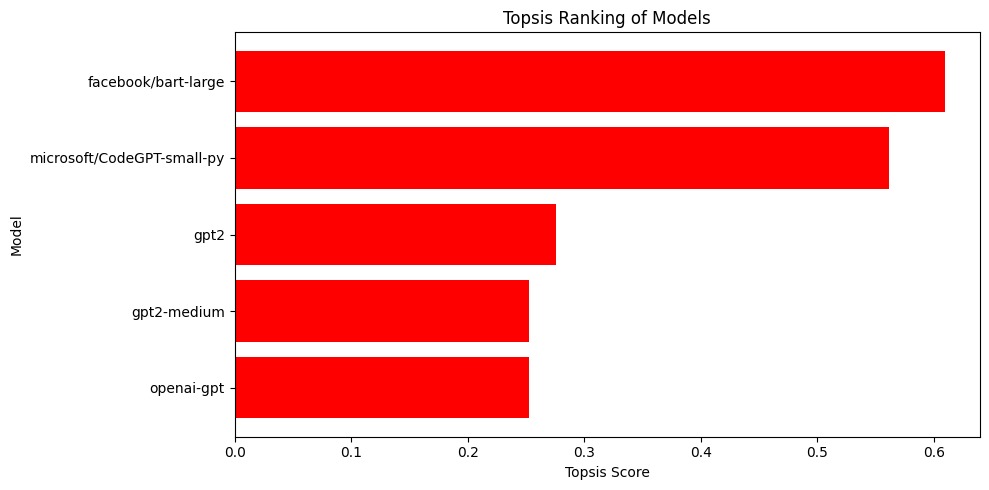

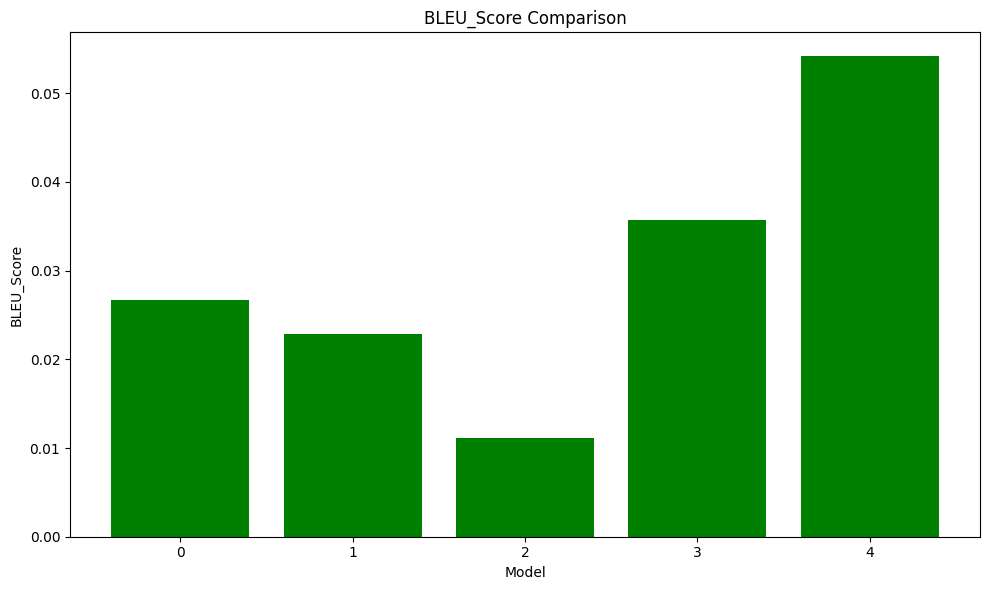

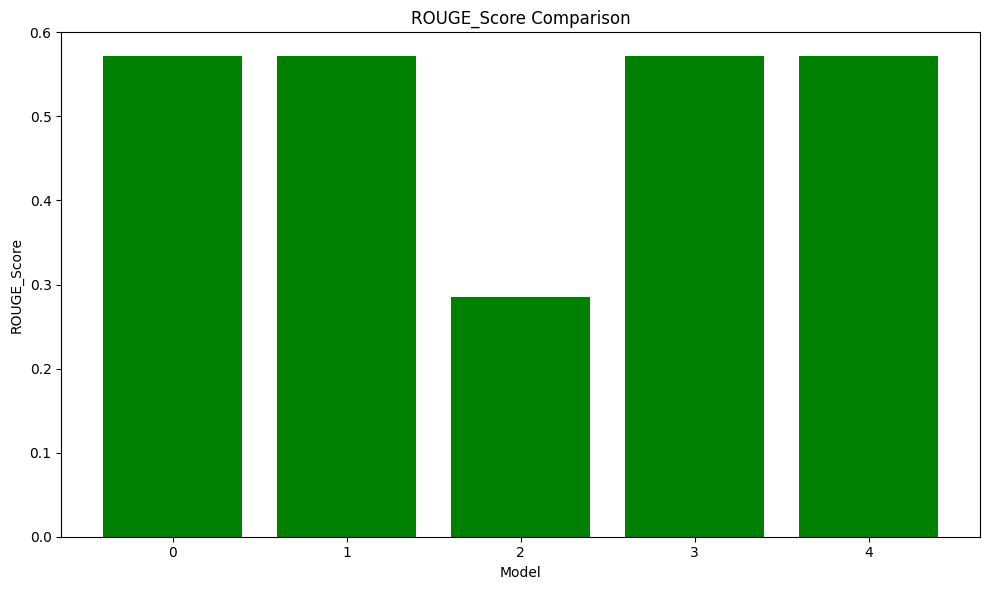

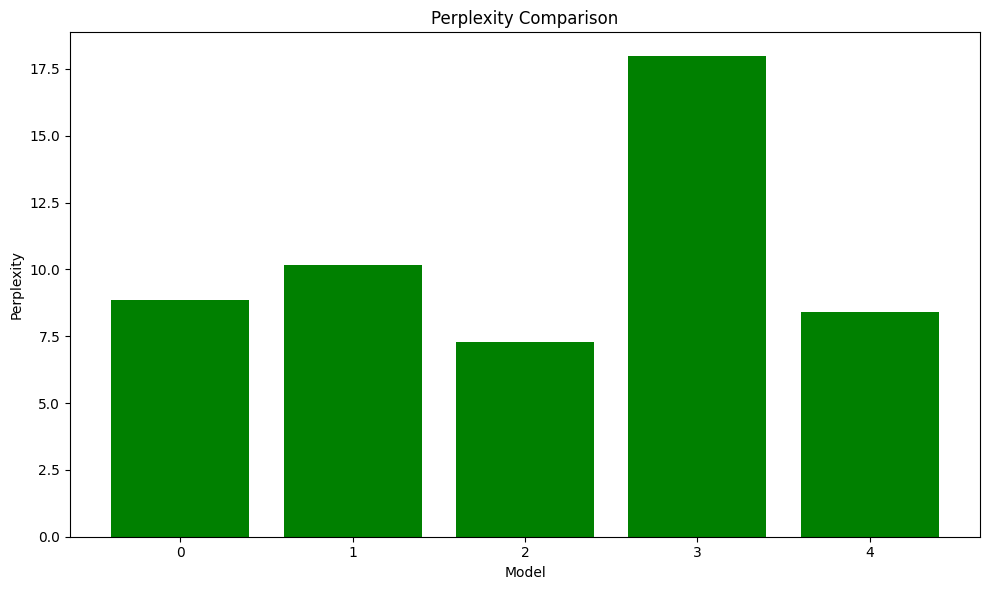

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk import ngrams

models = [
    "gpt2",
    "gpt2-medium",
    "openai-gpt",
    "facebook/bart-large",
    "microsoft/CodeGPT-small-py"
]

columns = ["Model", "BLEU_Score", "ROUGE_Score", "Perplexity"]
results = pd.DataFrame(columns=columns)

def evaluate_model(model_name, text_generator, tokenizer):
    # input_text = "Let's play"
    # reference = ["Let's play and have some fun"]

    input_text = "Let's go on and"
    reference = ["Let's go on trip and have some fun"]

    generated_text = text_generator(input_text, max_length=50, num_return_sequences=1, num_beams=5, no_repeat_ngram_size=2, return_tensors="pt")

    hypothesis = tokenizer.decode(generated_text[0]["generated_token_ids"], skip_special_tokens=True)

    reference_tokens = [reference[0].split()]
    hypothesis_tokens = hypothesis.split()

    bleu_score = sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=SmoothingFunction().method1)

    reference_ngrams = [set(ngrams(reference[0].split(), 2))]
    hypothesis_ngrams = set(ngrams(hypothesis.split(), 2))
    overlap = sum(len(ngram) for ngram in hypothesis_ngrams.intersection(*reference_ngrams))
    rouge_score = overlap / len(reference_ngrams[0])

    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    with torch.no_grad():
        logits = model(input_ids).logits
    perplexity = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), input_ids.view(-1))

    return bleu_score, rouge_score, perplexity.item()

for model_name in models:
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

    bleu_score, rouge_score, perplexity = evaluate_model(model_name, text_generator, tokenizer)

    results = results.append({
        "Model": model_name,
        "BLEU_Score": bleu_score,
        "ROUGE_Score": rouge_score,
        "Perplexity": perplexity
    }, ignore_index=True)

results.to_csv("Results.csv", index=False)
print("Evaluation and TOPSIS analysis completed. Results saved to 'model_evaluation_results.csv'.")
print(results)

data = pd.read_csv('Results.csv')

weights = '1,1,1'
impacts = '+,+,-'

if data.shape[1] < 3:
    raise ValueError("Input file does not contain three or more columns.")
if not data.iloc[:, 1:].apply(np.isreal).all().all():
    raise ValueError("Columns from 2nd to last do not contain numeric values only.")
if len(weights.split(',')) != len(impacts.split(',')) != data.shape[1] - 1:
    raise ValueError("Number of weights, impacts, and columns must be the same.")
if not all(impact in ['+', '-'] for impact in impacts.split(',')):
    raise ValueError("Impacts must be either +ve or -ve.")

norm_data = data.copy()
for i in range(1, data.shape[1]):
    norm_data.iloc[:, i] = data.iloc[:, i] / np.sqrt(np.sum(data.iloc[:, i]**2))

weights = np.array([float(weight) for weight in weights.split(',')])
weighted_norm_data = norm_data.copy()
for i in range(1, norm_data.shape[1]):
    weighted_norm_data.iloc[:, i] = norm_data.iloc[:, i] * weights[i-1]

ideal_value = []
worst_ideal_value = []

for i in range(1, weighted_norm_data.shape[1]):
    if impacts[i-1] == '+':
        ideal_value.append(weighted_norm_data.iloc[:, i].max())
        worst_ideal_value.append(weighted_norm_data.iloc[:, i].min())
    else:
        ideal_value.append(weighted_norm_data.iloc[:, i].min())
        worst_ideal_value.append(weighted_norm_data.iloc[:, i].max())

distance_to_ideal = np.sqrt(np.sum((weighted_norm_data.iloc[:, 1:] - ideal_value)**2, axis=1))
distance_to_worst_ideal = np.sqrt(np.sum((weighted_norm_data.iloc[:, 1:] - worst_ideal_value)**2, axis=1))

performace_score = distance_to_worst_ideal / (distance_to_ideal + distance_to_worst_ideal)

result_topsis = data.copy()
result_topsis['Topsis Score'] =  performace_score
result_topsis['Rank'] = result_topsis['Topsis Score'].rank(ascending=False)

result_topsis.to_csv("Topsis.csv", index=False)
result_file="Topsis.csv"
print(f"Topsis analysis completed successfully. Results saved to {result_file}")

topsis_results = pd.read_csv("Topsis.csv")
topsis_results_sorted = topsis_results.sort_values(by='Rank')


plt.figure(figsize=(10, 5))
plt.barh(topsis_results_sorted.iloc[:, 0], topsis_results_sorted['Topsis Score'], color='red')
plt.xlabel('Topsis Score')
plt.ylabel('Model')
plt.title('Topsis Ranking of Models')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('Topsis_BarGraph.png')
plt.show()

data = pd.read_csv('Results.csv')
metrics = ['BLEU_Score', 'ROUGE_Score', 'Perplexity']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(data.index, data[metric], color='green')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks()
    plt.tight_layout()
    plt.savefig(f'{metric}_Comparison.png')
    plt.show()